Epoch 1/20, Loss: 1.6987
Epoch 2/20, Loss: 0.4903
Epoch 3/20, Loss: 0.0991
Epoch 4/20, Loss: 0.1433
Epoch 5/20, Loss: 0.2712
Epoch 6/20, Loss: 0.2869
Epoch 7/20, Loss: 0.2125
Epoch 8/20, Loss: 0.1201
Epoch 9/20, Loss: 0.0529
Epoch 10/20, Loss: 0.0237
Epoch 11/20, Loss: 0.0268
Epoch 12/20, Loss: 0.0458
Epoch 13/20, Loss: 0.0646
Epoch 14/20, Loss: 0.0739
Epoch 15/20, Loss: 0.0716
Epoch 16/20, Loss: 0.0605
Epoch 17/20, Loss: 0.0455
Epoch 18/20, Loss: 0.0306
Epoch 19/20, Loss: 0.0189
Epoch 20/20, Loss: 0.0116


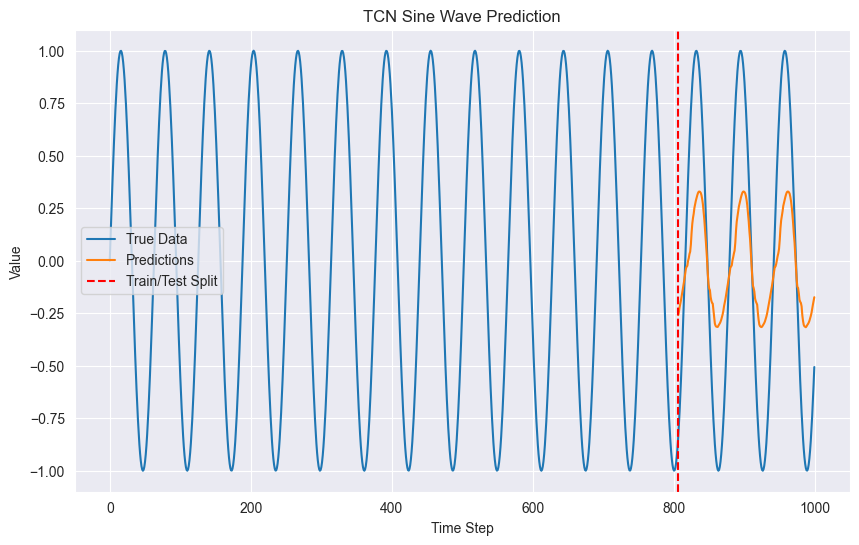

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle
# Define the Temporal Convolutional Network (TCN) Block
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(TCNBlock, self).__init__()
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            stride=1,
            dilation=dilation,
            padding=(kernel_size - 1) * dilation // 2,
        )
        self.relu = nn.ReLU()
        self.norm = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        out = self.norm(out)
        return out


# Define the Temporal Convolutional Network (TCN)
class TemporalConvNet(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=3):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i  # Exponential increase in dilation
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers.append(TCNBlock(in_channels, out_channels, kernel_size, dilation_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# Define a simple TCN model for sequence-to-sequence tasks
class TCNModel(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size)
        self.fc = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        out = self.tcn(x)  # TCN expects input in (batch_size, channels, seq_len)
        out = out[:, :, -1]  # Take the last time step output
        out = self.fc(out)
        return out


# Example usage: Predicting a sine wave
if __name__ == "__main__":
    # Generate sine wave data
    seq_length = 30
    data_points = 1000
    x = torch.linspace(0, 100, data_points)
    y = torch.sin(x)

    # Prepare data for TCN
    def create_sequences(data, seq_length):
        sequences = []
        targets = []
        for i in range(len(data) - seq_length):
            seq = data[i:i + seq_length]
            target = data[i + seq_length]
            sequences.append(seq)
            targets.append(target)
        return torch.stack(sequences), torch.stack(targets)

    sequences, targets = create_sequences(y, seq_length)
    sequences = sequences.unsqueeze(1)  # Add channel dimension

    # Train-test split
    train_size = int(0.8 * len(sequences))
    train_seq, test_seq = sequences[:train_size], sequences[train_size:]
    train_targets, test_targets = targets[:train_size], targets[train_size:]

    # Model parameters
    input_size = 1
    output_size = 1
    num_channels = [16, 32, 64]
    kernel_size = 3
    learning_rate = 0.001
    num_epochs = 20

    # Model, loss, and optimizer
    model = TCNModel(input_size, output_size, num_channels, kernel_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_seq)
        loss = criterion(output.squeeze(), train_targets)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(test_seq).squeeze()

    # Correct plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y.numpy(), label="True Data")  # Full sine wave
    plt.plot(range(train_size + seq_length, len(y)), predictions.numpy(), label="Predictions")  # Align predictions
    plt.axvline(train_size + seq_length, color='r', linestyle='--', label="Train/Test Split")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("TCN Sine Wave Prediction")
    plt.show()


In [10]:
# Load the list of DataFrames from the pickle file
with open('./data/split_dataset.pickle', 'rb') as f:
    split_dataset= pickle.load(f)
target_column = 'extreme_event'
#
X_train = split_dataset[0].drop(target_column, axis=1)
y_train = split_dataset[0][target_column]
#
X_val = split_dataset[1].drop(target_column, axis=1)
y_val = split_dataset[1][target_column]
#
X_test = split_dataset[2].drop(target_column, axis=1)
y_test = split_dataset[2][target_column]

In [11]:
X_train

,close_lag00,close_lag01,close_lag02,close_lag03,close_lag04,close_lag05,close_lag06,close_lag07,close_lag08,close_lag09,...,volume_lag01,volume_lag02,volume_lag03,volume_lag04,volume_lag05,volume_lag06,volume_lag07,volume_lag08,volume_lag09,volume_lag10
date,,,,,,,,,,,,,,,,,,,,,
2015-01-16,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,26.565001,26.562500,...,240056000.0,195826400.0,268367600.0,198603200.0,214798000.0,237458000.0,160423600.0,263188400.0,257142000.0,212818400.0
2015-01-20,27.180000,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,26.565001,...,314053200.0,240056000.0,195826400.0,268367600.0,198603200.0,214798000.0,237458000.0,160423600.0,263188400.0,257142000.0
2015-01-21,27.387501,27.180000,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,26.937500,...,199599600.0,314053200.0,240056000.0,195826400.0,268367600.0,198603200.0,214798000.0,237458000.0,160423600.0,263188400.0
2015-01-22,28.100000,27.387501,27.180000,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,27.972500,...,194303600.0,199599600.0,314053200.0,240056000.0,195826400.0,268367600.0,198603200.0,214798000.0,237458000.0,160423600.0
2015-01-23,28.245001,28.100000,27.387501,27.180000,26.497499,26.705000,27.450001,27.555000,27.312500,28.002501,...,215185600.0,194303600.0,199599600.0,314053200.0,240056000.0,195826400.0,268367600.0,198603200.0,214798000.0,237458000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-15,134.500000,132.029999,134.429993,131.240005,133.000000,130.360001,127.900002,126.209999,125.900002,123.000000,...,87222800.0,91266500.0,91420000.0,106686700.0,88844600.0,83466700.0,80171300.0,88651200.0,75089100.0,118323800.0
2021-04-16,134.160004,134.500000,132.029999,134.429993,131.240005,133.000000,130.360001,127.900002,126.209999,125.900002,...,89347100.0,87222800.0,91266500.0,91420000.0,106686700.0,88844600.0,83466700.0,80171300.0,88651200.0,75089100.0
2021-04-19,134.839996,134.160004,134.500000,132.029999,134.429993,131.240005,133.000000,130.360001,127.900002,126.209999,...,84922400.0,89347100.0,87222800.0,91266500.0,91420000.0,106686700.0,88844600.0,83466700.0,80171300.0,88651200.0


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Define the Temporal CNN Model
class TemporalCNN(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes=2):
        super(TemporalCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)  # First Conv layer
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)  # Second Conv layer
        self.relu = nn.ReLU()  # Activation function
        self.flatten = nn.Flatten()  # Flatten the output
        self.fc = nn.Linear(64 * sequence_length, num_classes)  # Fully connected layer
        self.softmax = nn.Softmax(dim=1)  # Softmax for output probabilities

    def forward(self, x):
        x = self.conv1(x)  # Apply first Conv layer
        x = self.relu(x)   # Apply ReLU
        x = self.conv2(x)  # Apply second Conv layer
        x = self.relu(x)   # Apply ReLU
        x = self.flatten(x)  # Flatten the features
        x = self.fc(x)  # Fully connected layer
        x = self.softmax(x)  # Softmax for probabilities
        return x

# Data Preparation
def prepare_data(X, y, seq_length=10, test_size=0.15, val_size=0.15):
    """
    Prepares data for training the Temporal CNN.
    - X: Feature matrix (shape: [samples, features, time_steps])
    - y: Labels (shape: [samples])
    """
    # Train/Test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size + val_size, random_state=42)

    # Split validation from test
    val_ratio = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_ratio, random_state=42)

    # Convert to PyTorch tensors
    X_train, X_val, X_test = map(torch.tensor, (X_train, X_val, X_test))
    y_train, y_val, y_test = map(torch.tensor, (y_train, y_val, y_test))

    return X_train.float(), y_train.long(), X_val.float(), y_val.long(), X_test.float(), y_test.long()

# Hyperparameters and Model Setup
input_channels = 7  # Features (open, high, low, close, volume, daily return, lagged)
sequence_length = 10  # Days
num_classes = 2  # Binary classification
learning_rate = 0.001
batch_size = 32
epochs = 20

# Example data generation (replace with your actual data)
np.random.seed(42)
num_samples = 1000
X = np.random.rand(num_samples, input_channels, sequence_length)  # Random continuous features
y = np.random.randint(0, 2, size=num_samples)  # Binary target

# Prepare data
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(X, y)

# Create the model
model = TemporalCNN(input_channels, sequence_length, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation Accuracy
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = accuracy_score(y_val, val_preds)

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_acc:.4f}")

# Test Accuracy
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = accuracy_score(y_test, test_preds)

print(f"Test Accuracy: {test_acc:.4f}")


Epoch [1/20], Loss: 0.6960, Val Accuracy: 0.5600
Epoch [2/20], Loss: 0.6942, Val Accuracy: 0.5067
Epoch [3/20], Loss: 0.6922, Val Accuracy: 0.5600
Epoch [4/20], Loss: 0.6895, Val Accuracy: 0.5733
Epoch [5/20], Loss: 0.6844, Val Accuracy: 0.5533
Epoch [6/20], Loss: 0.6779, Val Accuracy: 0.5600
Epoch [7/20], Loss: 0.6723, Val Accuracy: 0.5667
Epoch [8/20], Loss: 0.6665, Val Accuracy: 0.5733
Epoch [9/20], Loss: 0.6589, Val Accuracy: 0.5533
Epoch [10/20], Loss: 0.6527, Val Accuracy: 0.5533
Epoch [11/20], Loss: 0.6451, Val Accuracy: 0.5600
Epoch [12/20], Loss: 0.6377, Val Accuracy: 0.5533
Epoch [13/20], Loss: 0.6294, Val Accuracy: 0.5400
Epoch [14/20], Loss: 0.6208, Val Accuracy: 0.5333
Epoch [15/20], Loss: 0.6126, Val Accuracy: 0.5267
Epoch [16/20], Loss: 0.6035, Val Accuracy: 0.5267
Epoch [17/20], Loss: 0.5937, Val Accuracy: 0.5267
Epoch [18/20], Loss: 0.5841, Val Accuracy: 0.5200
Epoch [19/20], Loss: 0.5748, Val Accuracy: 0.5200
Epoch [20/20], Loss: 0.5641, Val Accuracy: 0.5200
Test Accu

In [18]:
y_train

date
2015-01-16    0
2015-01-20    1
2015-01-21    0
2015-01-22    0
2015-01-23    1
             ..
2021-04-15    0
2021-04-16    0
2021-04-19    0
2021-04-20    0
2021-04-21    0
Name: extreme_event, Length: 1576, dtype: int32